In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Functional

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

#Read the csv file
df = pd.read_csv('data/GE.csv')
print(df.head()) #7 columns, including the Date. 

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

2023-04-12 17:17:54.270024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 17:17:54.408508: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-12 17:17:54.421588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-12 17:17:54.421606: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
df = pd.read_csv('Varanasi.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Varanasi.csv'

In [ ]:
df.head()

In [ ]:
df.drop(columns =['PeriodEnd','Period','GtiFixedTilt','GtiTracking','Dhi','Ghi','Azimuth','Zenith','Dni','Ebh','SnowWater','WindDirection10m','AlbedoDaily'],axis =1,inplace =True)

In [ ]:
df.drop("CloudOpacity",axis=1,inplace =True)

In [ ]:
df.set_index(df['PeriodStart'], drop=False, append=False, inplace=True, verify_integrity=False)

In [ ]:
df.drop(columns =['PeriodStart'], axis =1,inplace =True)

In [ ]:
df= df.reset_index()

In [ ]:
df['PeriodStart'] =pd.to_datetime(df.PeriodStart)

In [ ]:
cols = list(df)[0:6]

In [ ]:
cols

['AirTemp',
 'DewpointTemp',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindSpeed10m']

In [ ]:
df_for_training = df[cols].astype(float)

In [ ]:
df_for_training

AirTemp  DewpointTemp  PrecipitableWater  \
PeriodStart                                                           
2007-01-01 01:00:00+00:00     13.0           9.7               18.4   
2007-01-01 02:00:00+00:00     14.0          10.2               18.3   
2007-01-01 03:00:00+00:00     15.7          10.5               18.1   
2007-01-01 04:00:00+00:00     18.2          10.6               18.0   
2007-01-01 05:00:00+00:00     20.7          10.8               17.9   
...                            ...           ...                ...   
2022-08-30 18:00:00+00:00     29.2          23.2               64.4   
2022-08-30 19:00:00+00:00     28.8          23.1               64.3   
2022-08-30 20:00:00+00:00     28.1          23.3               64.4   
2022-08-30 21:00:00+00:00     27.5          23.4               64.4   
2022-08-30 22:00:00+00:00     27.5          23.3               64.2   

                           RelativeHumidity  SurfacePressure  WindSpeed10m  
PeriodStart                                                                 
2007-01-01 01:00:00+00:00              80.2           1002.1           0.7  
2007-01-01 02:00:00+00:00              77.9           1002.7           0.7  
2007-01-01 03:00:00+00:00              71.2           1003.0           0.7  
2007-01-01 04:00:00+00:00              61.4           1003.1           0.9  
2007-01-01 05:00:00+00:00              53.1           1003.1           1.2  
...                                     ...              ...           ...  
2022-08-30 18:00:00+00:00              70.1            997.7           2.3  
2022-08-30 19:00:00+00:00              71.6            997.2           2.5  
2022-08-30 20:00:00+00:00              75.2            996.7           2.5  
2022-08-30 21:00:00+00:00              77.9            996.2           2.3  
2022-08-30 22:00:00+00:00              77.9            996.1           2.3  

[137302 rows x 6 columns]

<AxesSubplot:xlabel='PeriodStart'>

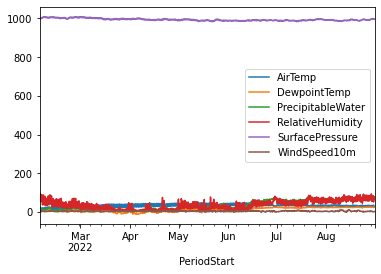

In [ ]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [ ]:
a=0
for i in df_for_training_scaled:
    print(a,i[-1])
    a=a+1
    

0 -1.3432863308468075
1 -1.3432863308468075
2 -1.3432863308468075
3 -1.1970484290648773
4 -0.9776915763919819
5 -0.6120968219371563
6 -0.24650206748233067
7 0.11909268697249487
8 0.2653305887544249
9 0.11909268697249487
10 0.0459737360815297
11 -0.02714521480943547
12 0.11909268697249487
13 0.1922116378634597
14 0.1922116378634597
15 0.1922116378634597
16 0.1922116378634597
17 0.11909268697249487
18 0.11909268697249487
19 0.0459737360815297
20 0.0459737360815297
21 -0.02714521480943547
22 -0.02714521480943547
23 0.11909268697249487
24 0.4846874414273204
25 0.8502821958821459
26 1.069639048555041
27 1.2158769503369715
28 1.4352338030098666
29 1.581471704791797
30 1.6545906556827619
31 1.800828557464692
32 1.581471704791797
33 0.9234011467731108
34 0.2653305887544249
35 -0.02714521480943547
36 0.0459737360815297
37 0.11909268697249487
38 0.1922116378634597
39 0.1922116378634597
40 0.1922116378634597
41 0.1922116378634597
42 0.2653305887544249
43 0.33844953964539004
44 0.33844953964539004

2085 -1.2701673799558422
2086 -1.4164052817377724
2087 -1.3432863308468075
2088 -1.3432863308468075
2089 -1.2701673799558422
2090 -1.3432863308468075
2091 -1.3432863308468075
2092 -1.2701673799558422
2093 -1.123929478173912
2094 -0.9776915763919819
2095 -0.7583347237190865
2096 -0.6852157728281213
2097 -0.7583347237190865
2098 -0.7583347237190865
2099 -0.6120968219371563
2100 -0.24650206748233067
2101 0.11909268697249487
2102 0.2653305887544249
2103 0.1922116378634597
2104 0.0459737360815297
2105 -0.17338311659136582
2106 -0.39273996926426097
2107 -0.6852157728281213
2108 -0.9045726255010167
2109 -1.123929478173912
2110 -1.1970484290648773
2111 -1.1970484290648773
2112 -1.4164052817377724
2113 -1.6357621344106679
2114 -1.7088810853016327
2115 -1.7820000361925978
2116 -1.7088810853016327
2117 -1.5626431835197028
2118 -1.4164052817377724
2119 -1.2701673799558422
2120 -1.123929478173912
2121 -0.9776915763919819
2122 -0.9045726255010167
2123 -0.6852157728281213
2124 -0.3196210183732958
212

4125 1.2889959012279364
4126 1.2158769503369715
4127 1.3621148521189017
4128 1.873947508355657
4129 2.385780164592413
4130 2.605137017265308
4131 2.5320180663743432
4132 2.385780164592413
4133 2.312661213701448
4134 2.312661213701448
4135 2.312661213701448
4136 2.0933043610285527
4137 1.800828557464692
4138 1.5083527539008315
4139 1.5083527539008315
4140 1.800828557464692
4141 2.0933043610285527
4142 2.2395422628104824
4143 2.312661213701448
4144 2.385780164592413
4145 2.312661213701448
4146 2.1664233119195178
4147 2.020185410137587
4148 1.9470664592466225
4149 1.9470664592466225
4150 2.020185410137587
4151 2.0933043610285527
4152 2.385780164592413
4153 2.605137017265308
4154 2.6782559681562734
4155 2.605137017265308
4156 2.5320180663743432
4157 2.458899115483378
4158 2.385780164592413
4159 2.385780164592413
4160 2.2395422628104824
4161 2.1664233119195178
4162 2.0933043610285527
4163 2.020185410137587
4164 1.9470664592466225
4165 1.873947508355657
4166 1.7277096065737274
4167 1.5814717

6429 -0.17338311659136582
6430 -0.02714521480943547
6431 0.0459737360815297
6432 0.0459737360815297
6433 0.0459737360815297
6434 0.11909268697249487
6435 0.2653305887544249
6436 0.41156849053635525
6437 0.33844953964539004
6438 -0.02714521480943547
6439 -0.17338311659136582
6440 -0.6852157728281213
6441 -1.6357621344106679
6442 -1.0508105272829469
6443 -0.4658589201552262
6444 -0.24650206748233067
6445 0.0459737360815297
6446 0.0459737360815297
6447 -0.24650206748233067
6448 -0.4658589201552262
6449 -0.6120968219371563
6450 -0.6120968219371563
6451 -0.6852157728281213
6452 -0.6852157728281213
6453 -0.7583347237190865
6454 -0.7583347237190865
6455 -0.6852157728281213
6456 -0.5389778710461912
6457 -0.4658589201552262
6458 -0.5389778710461912
6459 -0.6852157728281213
6460 -0.7583347237190865
6461 -0.7583347237190865
6462 -0.9045726255010167
6463 -0.9776915763919819
6464 -1.123929478173912
6465 -1.1970484290648773
6466 -1.2701673799558422
6467 -1.1970484290648773
6468 -1.1970484290648773
6

8542 -0.3196210183732958
8543 -0.24650206748233067
8544 -0.02714521480943547
8545 0.1922116378634597
8546 0.1922116378634597
8547 -0.02714521480943547
8548 -0.24650206748233067
8549 -0.3196210183732958
8550 -0.3196210183732958
8551 -0.3196210183732958
8552 -0.17338311659136582
8553 0.0459737360815297
8554 0.33844953964539004
8555 0.41156849053635525
8556 0.33844953964539004
8557 0.2653305887544249
8558 0.1922116378634597
8559 0.0459737360815297
8560 -0.02714521480943547
8561 -0.10026416570040064
8562 -0.24650206748233067
8563 -0.3196210183732958
8564 -0.4658589201552262
8565 -0.5389778710461912
8566 -0.6120968219371563
8567 -0.4658589201552262
8568 -0.10026416570040064
8569 0.2653305887544249
8570 0.33844953964539004
8571 0.1922116378634597
8572 0.11909268697249487
8573 0.1922116378634597
8574 0.2653305887544249
8575 0.33844953964539004
8576 0.41156849053635525
8577 0.4846874414273204
8578 0.4846874414273204
8579 0.41156849053635525
8580 0.2653305887544249
8581 0.1922116378634597
8582 

10530 0.11909268697249487
10531 0.0459737360815297
10532 -0.02714521480943547
10533 -0.17338311659136582
10534 -0.3196210183732958
10535 -0.3196210183732958
10536 -0.24650206748233067
10537 -0.17338311659136582
10538 -0.02714521480943547
10539 0.33844953964539004
10540 0.7040442941002156
10541 1.069639048555041
10542 1.3621148521189017
10543 1.7277096065737274
10544 1.5083527539008315
10545 0.7040442941002156
10546 -0.10026416570040064
10547 -0.3196210183732958
10548 -0.10026416570040064
10549 0.1922116378634597
10550 0.1922116378634597
10551 -0.02714521480943547
10552 -0.17338311659136582
10553 -0.24650206748233067
10554 -0.39273996926426097
10555 -0.4658589201552262
10556 -0.4658589201552262
10557 -0.4658589201552262
10558 -0.39273996926426097
10559 -0.3196210183732958
10560 -0.17338311659136582
10561 -0.02714521480943547
10562 0.0459737360815297
10563 0.2653305887544249
10564 0.5578063923182852
10565 0.8502821958821459
10566 1.142757999446006
10567 1.5083527539008315
10568 1.2889959

12661 -0.9776915763919819
12662 -0.9776915763919819
12663 -0.9776915763919819
12664 -0.9045726255010167
12665 -0.9045726255010167
12666 -0.9776915763919819
12667 -1.0508105272829469
12668 -1.0508105272829469
12669 -0.9776915763919819
12670 -0.8314536746100517
12671 -0.6120968219371563
12672 -0.39273996926426097
12673 -0.17338311659136582
12674 -0.02714521480943547
12675 -0.10026416570040064
12676 -0.10026416570040064
12677 -0.17338311659136582
12678 -0.3196210183732958
12679 -0.39273996926426097
12680 -0.4658589201552262
12681 -0.4658589201552262
12682 -0.4658589201552262
12683 -0.4658589201552262
12684 -0.5389778710461912
12685 -0.6120968219371563
12686 -0.6852157728281213
12687 -0.7583347237190865
12688 -0.8314536746100517
12689 -0.8314536746100517
12690 -0.8314536746100517
12691 -0.8314536746100517
12692 -0.6852157728281213
12693 -0.39273996926426097
12694 -0.10026416570040064
12695 0.2653305887544249
12696 0.7040442941002156
12697 1.142757999446006
12698 1.2889959012279364
12699 1.

14718 0.11909268697249487
14719 -0.02714521480943547
14720 -0.3196210183732958
14721 -0.7583347237190865
14722 -1.1970484290648773
14723 -1.4164052817377724
14724 -1.3432863308468075
14725 -1.0508105272829469
14726 -0.9045726255010167
14727 -0.9045726255010167
14728 -0.9045726255010167
14729 -0.9045726255010167
14730 -0.9045726255010167
14731 -0.9776915763919819
14732 -0.9776915763919819
14733 -0.9045726255010167
14734 -0.8314536746100517
14735 -1.0508105272829469
14736 -1.3432863308468075
14737 -1.2701673799558422
14738 -0.9045726255010167
14739 -0.5389778710461912
14740 -0.10026416570040064
14741 0.0459737360815297
14742 -0.02714521480943547
14743 -0.17338311659136582
14744 -0.5389778710461912
14745 -1.1970484290648773
14746 -1.6357621344106679
14747 -1.3432863308468075
14748 -1.0508105272829469
14749 -0.7583347237190865
14750 -0.6852157728281213
14751 -0.7583347237190865
14752 -0.8314536746100517
14753 -0.9776915763919819
14754 -1.1970484290648773
14755 -1.4164052817377724
14756 -1.

16911 -1.5626431835197028
16912 -1.5626431835197028
16913 -1.3432863308468075
16914 -1.2701673799558422
16915 -1.123929478173912
16916 -0.9776915763919819
16917 -0.9045726255010167
16918 -0.8314536746100517
16919 -0.6852157728281213
16920 -0.6120968219371563
16921 -0.4658589201552262
16922 -0.5389778710461912
16923 -0.8314536746100517
16924 -1.0508105272829469
16925 -1.0508105272829469
16926 -1.0508105272829469
16927 -0.9045726255010167
16928 -0.7583347237190865
16929 -0.6120968219371563
16930 -0.4658589201552262
16931 -0.6120968219371563
16932 -1.1970484290648773
16933 -1.4164052817377724
16934 -1.2701673799558422
16935 -1.0508105272829469
16936 -0.9045726255010167
16937 -0.7583347237190865
16938 -0.7583347237190865
16939 -0.7583347237190865
16940 -0.6852157728281213
16941 -0.6120968219371563
16942 -0.4658589201552262
16943 -0.5389778710461912
16944 -0.7583347237190865
16945 -0.9045726255010167
16946 -1.0508105272829469
16947 -1.1970484290648773
16948 -1.2701673799558422
16949 -1.3432

19161 0.7040442941002156
19162 0.41156849053635525
19163 -0.10026416570040064
19164 -0.4658589201552262
19165 -0.3196210183732958
19166 -0.24650206748233067
19167 -0.39273996926426097
19168 -0.39273996926426097
19169 -0.4658589201552262
19170 -0.5389778710461912
19171 -0.5389778710461912
19172 -0.4658589201552262
19173 -0.5389778710461912
19174 -0.4658589201552262
19175 -0.5389778710461912
19176 -0.6120968219371563
19177 -0.6852157728281213
19178 -0.7583347237190865
19179 -0.8314536746100517
19180 -0.9045726255010167
19181 -0.8314536746100517
19182 -0.6852157728281213
19183 -0.5389778710461912
19184 -0.39273996926426097
19185 -0.3196210183732958
19186 -0.24650206748233067
19187 -0.17338311659136582
19188 -0.02714521480943547
19189 0.11909268697249487
19190 0.1922116378634597
19191 0.11909268697249487
19192 0.0459737360815297
19193 -0.02714521480943547
19194 0.0459737360815297
19195 0.0459737360815297
19196 0.0459737360815297
19197 -0.02714521480943547
19198 0.0459737360815297
19199 0.0

21410 -0.9776915763919819
21411 -0.39273996926426097
21412 0.33844953964539004
21413 0.8502821958821459
21414 1.2158769503369715
21415 1.581471704791797
21416 1.6545906556827619
21417 1.2889959012279364
21418 0.9234011467731108
21419 0.6309253432092504
21420 0.41156849053635525
21421 0.1922116378634597
21422 -0.10026416570040064
21423 -0.39273996926426097
21424 -0.6120968219371563
21425 -0.8314536746100517
21426 -1.0508105272829469
21427 -1.1970484290648773
21428 -1.4164052817377724
21429 -1.4895242326287377
21430 -1.2701673799558422
21431 -1.2701673799558422
21432 -1.4895242326287377
21433 -1.7088810853016327
21434 -1.5626431835197028
21435 -1.1970484290648773
21436 -0.8314536746100517
21437 -0.39273996926426097
21438 0.1922116378634597
21439 0.8502821958821459
21440 0.9965200976640759
21441 0.7040442941002156
21442 0.33844953964539004
21443 -0.02714521480943547
21444 -0.39273996926426097
21445 -0.7583347237190865
21446 -0.9045726255010167
21447 -0.9045726255010167
21448 -0.7583347237

23743 1.069639048555041
23744 0.7771632449911807
23745 0.1922116378634597
23746 -0.39273996926426097
23747 -0.6120968219371563
23748 -0.4658589201552262
23749 -0.24650206748233067
23750 -0.17338311659136582
23751 -0.3196210183732958
23752 -0.4658589201552262
23753 -0.4658589201552262
23754 -0.4658589201552262
23755 -0.39273996926426097
23756 -0.39273996926426097
23757 -0.4658589201552262
23758 -0.4658589201552262
23759 -0.39273996926426097
23760 -0.3196210183732958
23761 -0.24650206748233067
23762 -0.17338311659136582
23763 -0.02714521480943547
23764 0.11909268697249487
23765 0.2653305887544249
23766 0.2653305887544249
23767 0.2653305887544249
23768 0.11909268697249487
23769 -0.10026416570040064
23770 -0.39273996926426097
23771 -0.4658589201552262
23772 -0.3196210183732958
23773 -0.17338311659136582
23774 -0.24650206748233067
23775 -0.5389778710461912
23776 -0.6852157728281213
23777 -0.7583347237190865
23778 -0.6852157728281213
23779 -0.6120968219371563
23780 -0.6120968219371563
23781 

25917 -0.39273996926426097
25918 -0.4658589201552262
25919 -0.39273996926426097
25920 -0.3196210183732958
25921 -0.17338311659136582
25922 -0.10026416570040064
25923 -0.10026416570040064
25924 -0.10026416570040064
25925 0.0459737360815297
25926 0.1922116378634597
25927 0.41156849053635525
25928 0.33844953964539004
25929 0.11909268697249487
25930 -0.10026416570040064
25931 -0.24650206748233067
25932 -0.24650206748233067
25933 -0.17338311659136582
25934 -0.10026416570040064
25935 -0.02714521480943547
25936 0.0459737360815297
25937 0.0459737360815297
25938 -0.02714521480943547
25939 -0.10026416570040064
25940 -0.17338311659136582
25941 -0.3196210183732958
25942 -0.39273996926426097
25943 -0.3196210183732958
25944 -0.02714521480943547
25945 0.2653305887544249
25946 0.41156849053635525
25947 0.4846874414273204
25948 0.4846874414273204
25949 0.4846874414273204
25950 0.33844953964539004
25951 0.1922116378634597
25952 -0.02714521480943547
25953 -0.17338311659136582
25954 -0.17338311659136582
2

28410 -0.02714521480943547
28411 -0.10026416570040064
28412 -0.17338311659136582
28413 -0.3196210183732958
28414 -0.39273996926426097
28415 -0.39273996926426097
28416 -0.3196210183732958
28417 -0.24650206748233067
28418 -0.17338311659136582
28419 -0.02714521480943547
28420 0.2653305887544249
28421 0.7040442941002156
28422 1.2889959012279364
28423 1.873947508355657
28424 1.800828557464692
28425 1.069639048555041
28426 0.33844953964539004
28427 0.11909268697249487
28428 0.2653305887544249
28429 0.5578063923182852
28430 0.41156849053635525
28431 -0.02714521480943547
28432 -0.4658589201552262
28433 -0.9776915763919819
28434 -1.2701673799558422
28435 -0.9776915763919819
28436 -0.6852157728281213
28437 -0.5389778710461912
28438 -0.4658589201552262
28439 -0.17338311659136582
28440 0.2653305887544249
28441 0.7040442941002156
28442 0.9234011467731108
28443 1.069639048555041
28444 1.2889959012279364
28445 1.7277096065737274
28446 2.2395422628104824
28447 2.824493869938204
28448 2.751374919047238

30409 -0.17338311659136582
30410 -0.10026416570040064
30411 -0.17338311659136582
30412 -0.17338311659136582
30413 -0.3196210183732958
30414 -0.6852157728281213
30415 -0.7583347237190865
30416 -0.9045726255010167
30417 -1.123929478173912
30418 -0.9776915763919819
30419 -0.6120968219371563
30420 -0.17338311659136582
30421 0.1922116378634597
30422 0.4846874414273204
30423 0.6309253432092504
30424 0.7771632449911807
30425 0.7771632449911807
30426 0.7040442941002156
30427 0.5578063923182852
30428 0.1922116378634597
30429 -0.39273996926426097
30430 -0.8314536746100517
30431 -0.9776915763919819
30432 -0.6852157728281213
30433 -0.3196210183732958
30434 -0.24650206748233067
30435 -0.3196210183732958
30436 -0.17338311659136582
30437 -0.02714521480943547
30438 0.11909268697249487
30439 0.41156849053635525
30440 0.6309253432092504
30441 0.8502821958821459
30442 1.069639048555041
30443 1.069639048555041
30444 0.9234011467731108
30445 1.069639048555041
30446 1.2158769503369715
30447 1.06963904855504

32472 -0.17338311659136582
32473 -0.17338311659136582
32474 -0.10026416570040064
32475 -0.10026416570040064
32476 -0.02714521480943547
32477 0.0459737360815297
32478 0.0459737360815297
32479 0.11909268697249487
32480 0.0459737360815297
32481 -0.24650206748233067
32482 -0.4658589201552262
32483 -0.4658589201552262
32484 -0.3196210183732958
32485 -0.10026416570040064
32486 0.0459737360815297
32487 0.11909268697249487
32488 0.1922116378634597
32489 0.2653305887544249
32490 0.33844953964539004
32491 0.41156849053635525
32492 0.41156849053635525
32493 0.41156849053635525
32494 0.41156849053635525
32495 0.4846874414273204
32496 0.6309253432092504
32497 0.7771632449911807
32498 0.8502821958821459
32499 0.7771632449911807
32500 0.7771632449911807
32501 0.7771632449911807
32502 0.7771632449911807
32503 0.7771632449911807
32504 0.5578063923182852
32505 0.11909268697249487
32506 -0.3196210183732958
32507 -0.4658589201552262
32508 -0.39273996926426097
32509 -0.3196210183732958
32510 -0.17338311659

34590 1.5083527539008315
34591 1.5083527539008315
34592 1.2889959012279364
34593 0.7771632449911807
34594 0.2653305887544249
34595 0.0459737360815297
34596 -0.02714521480943547
34597 -0.02714521480943547
34598 -0.02714521480943547
34599 -0.10026416570040064
34600 -0.10026416570040064
34601 -0.17338311659136582
34602 -0.17338311659136582
34603 -0.24650206748233067
34604 -0.3196210183732958
34605 -0.39273996926426097
34606 -0.4658589201552262
34607 -0.4658589201552262
34608 -0.39273996926426097
34609 -0.3196210183732958
34610 -0.39273996926426097
34611 -0.5389778710461912
34612 -0.6120968219371563
34613 -0.5389778710461912
34614 -0.5389778710461912
34615 -0.5389778710461912
34616 -0.4658589201552262
34617 -0.39273996926426097
34618 -0.24650206748233067
34619 -0.10026416570040064
34620 -0.02714521480943547
34621 0.0459737360815297
34622 0.0459737360815297
34623 -0.10026416570040064
34624 -0.17338311659136582
34625 -0.24650206748233067
34626 -0.3196210183732958
34627 -0.39273996926426097
3

36817 -1.0508105272829469
36818 -0.9776915763919819
36819 -0.7583347237190865
36820 -0.4658589201552262
36821 -0.3196210183732958
36822 -0.10026416570040064
36823 0.0459737360815297
36824 -0.02714521480943547
36825 -0.3196210183732958
36826 -0.6120968219371563
36827 -0.5389778710461912
36828 -0.10026416570040064
36829 0.33844953964539004
36830 0.41156849053635525
36831 0.1922116378634597
36832 0.11909268697249487
36833 0.0459737360815297
36834 0.0459737360815297
36835 0.0459737360815297
36836 -0.3196210183732958
36837 -1.1970484290648773
36838 -1.6357621344106679
36839 -1.123929478173912
36840 -0.9776915763919819
36841 -0.7583347237190865
36842 -0.6120968219371563
36843 -0.5389778710461912
36844 -0.3196210183732958
36845 -0.17338311659136582
36846 0.0459737360815297
36847 0.2653305887544249
36848 0.1922116378634597
36849 -0.10026416570040064
36850 -0.39273996926426097
36851 -0.39273996926426097
36852 -0.02714521480943547
36853 0.33844953964539004
36854 0.33844953964539004
36855 -0.0271

38959 -0.8314536746100517
38960 -0.7583347237190865
38961 -0.5389778710461912
38962 -0.17338311659136582
38963 0.11909268697249487
38964 0.33844953964539004
38965 0.7040442941002156
38966 0.9234011467731108
38967 0.9234011467731108
38968 0.9234011467731108
38969 0.9234011467731108
38970 0.7771632449911807
38971 0.6309253432092504
38972 0.6309253432092504
38973 0.6309253432092504
38974 0.7040442941002156
38975 0.7040442941002156
38976 0.6309253432092504
38977 0.5578063923182852
38978 0.2653305887544249
38979 -0.3196210183732958
38980 -0.6852157728281213
38981 -0.8314536746100517
38982 -0.6852157728281213
38983 -0.5389778710461912
38984 -0.4658589201552262
38985 -0.3196210183732958
38986 -0.10026416570040064
38987 0.1922116378634597
38988 0.33844953964539004
38989 0.5578063923182852
38990 0.6309253432092504
38991 0.6309253432092504
38992 0.5578063923182852
38993 0.5578063923182852
38994 0.5578063923182852
38995 0.5578063923182852
38996 0.4846874414273204
38997 0.2653305887544249
38998 0.

41197 -0.9045726255010167
41198 -0.9776915763919819
41199 -0.9776915763919819
41200 -0.9776915763919819
41201 -0.9776915763919819
41202 -1.0508105272829469
41203 -1.0508105272829469
41204 -1.123929478173912
41205 -1.3432863308468075
41206 -1.4895242326287377
41207 -1.4895242326287377
41208 -1.3432863308468075
41209 -1.1970484290648773
41210 -1.3432863308468075
41211 -1.6357621344106679
41212 -1.4895242326287377
41213 -1.2701673799558422
41214 -1.123929478173912
41215 -0.9776915763919819
41216 -1.123929478173912
41217 -1.4164052817377724
41218 -1.3432863308468075
41219 -1.2701673799558422
41220 -1.2701673799558422
41221 -1.1970484290648773
41222 -1.1970484290648773
41223 -1.1970484290648773
41224 -1.2701673799558422
41225 -1.1970484290648773
41226 -1.123929478173912
41227 -1.0508105272829469
41228 -0.9776915763919819
41229 -0.9776915763919819
41230 -0.9776915763919819
41231 -1.0508105272829469
41232 -1.2701673799558422
41233 -1.4164052817377724
41234 -1.2701673799558422
41235 -0.9045726

43165 -1.2701673799558422
43166 -1.0508105272829469
43167 -0.9776915763919819
43168 -0.8314536746100517
43169 -0.7583347237190865
43170 -0.7583347237190865
43171 -0.7583347237190865
43172 -0.7583347237190865
43173 -0.7583347237190865
43174 -0.7583347237190865
43175 -0.7583347237190865
43176 -0.7583347237190865
43177 -0.7583347237190865
43178 -0.8314536746100517
43179 -0.9045726255010167
43180 -1.0508105272829469
43181 -1.123929478173912
43182 -1.0508105272829469
43183 -0.9045726255010167
43184 -0.9045726255010167
43185 -0.9045726255010167
43186 -0.7583347237190865
43187 -0.6852157728281213
43188 -0.9045726255010167
43189 -0.9045726255010167
43190 -0.9776915763919819
43191 -0.9776915763919819
43192 -0.8314536746100517
43193 -0.6852157728281213
43194 -0.6120968219371563
43195 -0.6120968219371563
43196 -0.6120968219371563
43197 -0.6120968219371563
43198 -0.6120968219371563
43199 -0.6120968219371563
43200 -0.5389778710461912
43201 -0.4658589201552262
43202 -0.5389778710461912
43203 -0.7583

45658 -0.5389778710461912
45659 -0.6120968219371563
45660 -0.39273996926426097
45661 -0.10026416570040064
45662 0.0459737360815297
45663 -0.10026416570040064
45664 -0.17338311659136582
45665 -0.17338311659136582
45666 -0.24650206748233067
45667 -0.24650206748233067
45668 -0.24650206748233067
45669 -0.24650206748233067
45670 -0.17338311659136582
45671 -0.24650206748233067
45672 -0.24650206748233067
45673 -0.3196210183732958
45674 -0.4658589201552262
45675 -0.6852157728281213
45676 -0.8314536746100517
45677 -1.1970484290648773
45678 -1.4164052817377724
45679 -1.123929478173912
45680 -0.9045726255010167
45681 -0.8314536746100517
45682 -0.7583347237190865
45683 -0.6120968219371563
45684 -0.3196210183732958
45685 0.11909268697249487
45686 0.1922116378634597
45687 0.0459737360815297
45688 0.0459737360815297
45689 -0.10026416570040064
45690 -0.3196210183732958
45691 -0.39273996926426097
45692 -0.39273996926426097
45693 -0.3196210183732958
45694 -0.3196210183732958
45695 -0.3196210183732958
45

47657 0.11909268697249487
47658 0.2653305887544249
47659 0.41156849053635525
47660 0.33844953964539004
47661 0.1922116378634597
47662 0.0459737360815297
47663 0.0459737360815297
47664 0.2653305887544249
47665 0.4846874414273204
47666 0.9234011467731108
47667 1.581471704791797
47668 2.2395422628104824
47669 2.6782559681562734
47670 2.824493869938204
47671 3.043850722611099
47672 2.9707317717201334
47673 2.7513749190472385
47674 2.5320180663743432
47675 2.020185410137587
47676 1.2158769503369715
47677 0.4846874414273204
47678 0.11909268697249487
47679 0.11909268697249487
47680 0.11909268697249487
47681 0.2653305887544249
47682 0.41156849053635525
47683 0.6309253432092504
47684 0.6309253432092504
47685 0.41156849053635525
47686 0.2653305887544249
47687 0.41156849053635525
47688 0.8502821958821459
47689 1.3621148521189017
47690 1.800828557464692
47691 2.2395422628104824
47692 2.7513749190472385
47693 3.043850722611099
47694 3.043850722611099
47695 3.043850722611099
47696 2.8976128208291687

49656 -0.3196210183732958
49657 -0.24650206748233067
49658 -0.24650206748233067
49659 -0.4658589201552262
49660 -0.6852157728281213
49661 -0.7583347237190865
49662 -0.7583347237190865
49663 -0.6852157728281213
49664 -0.6852157728281213
49665 -0.7583347237190865
49666 -0.8314536746100517
49667 -0.9045726255010167
49668 -0.9045726255010167
49669 -0.9045726255010167
49670 -0.9045726255010167
49671 -0.9045726255010167
49672 -0.9776915763919819
49673 -0.9776915763919819
49674 -0.9776915763919819
49675 -0.9776915763919819
49676 -0.9045726255010167
49677 -0.8314536746100517
49678 -0.7583347237190865
49679 -0.6852157728281213
49680 -0.5389778710461912
49681 -0.39273996926426097
49682 -0.3196210183732958
49683 -0.24650206748233067
49684 -0.17338311659136582
49685 -0.24650206748233067
49686 -0.3196210183732958
49687 -0.4658589201552262
49688 -0.5389778710461912
49689 -0.6852157728281213
49690 -0.7583347237190865
49691 -0.8314536746100517
49692 -0.7583347237190865
49693 -0.6852157728281213
49694 

51840 -0.24650206748233067
51841 -0.10026416570040064
51842 -0.10026416570040064
51843 -0.10026416570040064
51844 -0.02714521480943547
51845 0.1922116378634597
51846 0.41156849053635525
51847 0.6309253432092504
51848 0.6309253432092504
51849 0.4846874414273204
51850 0.2653305887544249
51851 0.1922116378634597
51852 0.2653305887544249
51853 0.2653305887544249
51854 0.2653305887544249
51855 0.2653305887544249
51856 0.1922116378634597
51857 0.1922116378634597
51858 0.1922116378634597
51859 0.11909268697249487
51860 0.0459737360815297
51861 -0.10026416570040064
51862 -0.17338311659136582
51863 -0.24650206748233067
51864 -0.24650206748233067
51865 -0.24650206748233067
51866 -0.17338311659136582
51867 -0.02714521480943547
51868 0.11909268697249487
51869 0.2653305887544249
51870 0.33844953964539004
51871 0.41156849053635525
51872 0.41156849053635525
51873 0.41156849053635525
51874 0.33844953964539004
51875 0.2653305887544249
51876 0.0459737360815297
51877 -0.02714521480943547
51878 -0.1002641

54157 0.0459737360815297
54158 0.11909268697249487
54159 0.0459737360815297
54160 0.0459737360815297
54161 -0.10026416570040064
54162 -0.17338311659136582
54163 -0.3196210183732958
54164 -0.3196210183732958
54165 -0.39273996926426097
54166 -0.39273996926426097
54167 -0.3196210183732958
54168 -0.17338311659136582
54169 -0.10026416570040064
54170 -0.17338311659136582
54171 -0.24650206748233067
54172 -0.17338311659136582
54173 -0.02714521480943547
54174 0.0459737360815297
54175 0.1922116378634597
54176 0.11909268697249487
54177 -0.10026416570040064
54178 -0.39273996926426097
54179 -0.3196210183732958
54180 -0.10026416570040064
54181 0.1922116378634597
54182 0.1922116378634597
54183 0.11909268697249487
54184 -0.02714521480943547
54185 -0.17338311659136582
54186 -0.3196210183732958
54187 -0.4658589201552262
54188 -0.5389778710461912
54189 -0.6120968219371563
54190 -0.6852157728281213
54191 -0.6852157728281213
54192 -0.6120968219371563
54193 -0.5389778710461912
54194 -0.4658589201552262
5419

56156 0.6309253432092504
56157 0.41156849053635525
56158 0.11909268697249487
56159 0.11909268697249487
56160 0.2653305887544249
56161 0.41156849053635525
56162 0.33844953964539004
56163 0.1922116378634597
56164 0.0459737360815297
56165 0.0459737360815297
56166 0.1922116378634597
56167 0.5578063923182852
56168 0.8502821958821459
56169 0.9234011467731108
56170 1.069639048555041
56171 0.8502821958821459
56172 0.41156849053635525
56173 0.11909268697249487
56174 0.2653305887544249
56175 0.6309253432092504
56176 1.2158769503369715
56177 1.4352338030098666
56178 1.2889959012279364
56179 1.069639048555041
56180 0.8502821958821459
56181 0.6309253432092504
56182 0.33844953964539004
56183 0.2653305887544249
56184 0.4846874414273204
56185 0.7771632449911807
56186 0.7771632449911807
56187 0.7771632449911807
56188 0.7771632449911807
56189 0.9234011467731108
56190 0.9965200976640759
56191 1.142757999446006
56192 1.2889959012279364
56193 1.5083527539008315
56194 1.800828557464692
56195 1.9470664592466

58156 2.6782559681562734
58157 2.605137017265308
58158 2.2395422628104824
58159 1.9470664592466225
58160 1.5083527539008315
58161 1.142757999446006
58162 0.7040442941002156
58163 0.41156849053635525
58164 0.2653305887544249
58165 0.11909268697249487
58166 0.1922116378634597
58167 0.41156849053635525
58168 0.7040442941002156
58169 0.9234011467731108
58170 1.2158769503369715
58171 1.4352338030098666
58172 1.581471704791797
58173 1.6545906556827619
58174 1.7277096065737274
58175 2.0933043610285527
58176 2.605137017265308
58177 3.116969673502064
58178 3.4094454770659244
58179 3.555683378847855
58180 3.6288023297388197
58181 3.7019212806297848
58182 3.7750402315207503
58183 3.9212781333026805
58184 3.848159182411715
58185 3.7019212806297848
58186 3.4825644279568895
58187 3.3363265261749593
58188 3.1900886243930295
58189 3.043850722611099
58190 2.8976128208291687
58191 2.8976128208291687
58192 2.8976128208291687
58193 2.9707317717201334
58194 3.116969673502064
58195 3.1900886243930295
58196 

60428 -0.5389778710461912
60429 -0.6852157728281213
60430 -0.7583347237190865
60431 -0.7583347237190865
60432 -0.7583347237190865
60433 -0.7583347237190865
60434 -0.7583347237190865
60435 -0.7583347237190865
60436 -0.6852157728281213
60437 -0.6120968219371563
60438 -0.39273996926426097
60439 -0.24650206748233067
60440 -0.10026416570040064
60441 -0.02714521480943547
60442 0.0459737360815297
60443 0.11909268697249487
60444 0.11909268697249487
60445 0.11909268697249487
60446 0.11909268697249487
60447 0.11909268697249487
60448 0.0459737360815297
60449 0.0459737360815297
60450 -0.02714521480943547
60451 -0.10026416570040064
60452 -0.17338311659136582
60453 -0.3196210183732958
60454 -0.4658589201552262
60455 -0.6852157728281213
60456 -0.7583347237190865
60457 -0.8314536746100517
60458 -0.9045726255010167
60459 -0.9776915763919819
60460 -0.9045726255010167
60461 -0.7583347237190865
60462 -0.5389778710461912
60463 -0.3196210183732958
60464 -0.17338311659136582
60465 -0.10026416570040064
60466 

62406 -1.0508105272829469
62407 -1.0508105272829469
62408 -1.0508105272829469
62409 -1.0508105272829469
62410 -0.9776915763919819
62411 -0.9045726255010167
62412 -0.8314536746100517
62413 -0.6852157728281213
62414 -0.5389778710461912
62415 -0.3196210183732958
62416 -0.17338311659136582
62417 -0.02714521480943547
62418 0.11909268697249487
62419 0.2653305887544249
62420 0.41156849053635525
62421 0.41156849053635525
62422 0.4846874414273204
62423 0.6309253432092504
62424 0.9234011467731108
62425 1.2889959012279364
62426 1.4352338030098666
62427 1.5083527539008315
62428 1.5083527539008315
62429 1.3621148521189017
62430 1.142757999446006
62431 0.9234011467731108
62432 0.7771632449911807
62433 0.7771632449911807
62434 0.7040442941002156
62435 0.7040442941002156
62436 0.7040442941002156
62437 0.7771632449911807
62438 0.7040442941002156
62439 0.6309253432092504
62440 0.5578063923182852
62441 0.4846874414273204
62442 0.41156849053635525
62443 0.41156849053635525
62444 0.33844953964539004
62445 

64570 2.312661213701448
64571 1.9470664592466225
64572 1.6545906556827619
64573 1.3621148521189017
64574 1.142757999446006
64575 1.069639048555041
64576 0.9965200976640759
64577 0.8502821958821459
64578 0.7040442941002156
64579 0.6309253432092504
64580 0.6309253432092504
64581 0.7771632449911807
64582 0.9234011467731108
64583 1.2158769503369715
64584 1.581471704791797
64585 2.020185410137587
64586 2.385780164592413
64587 2.824493869938204
64588 3.1900886243930295
64589 3.4094454770659244
64590 3.4094454770659244
64591 3.4094454770659244
64592 3.1900886243930295
64593 2.7513749190472385
64594 2.385780164592413
64595 1.873947508355657
64596 1.3621148521189017
64597 0.7771632449911807
64598 0.5578063923182852
64599 0.4846874414273204
64600 0.41156849053635525
64601 0.33844953964539004
64602 0.2653305887544249
64603 0.2653305887544249
64604 0.1922116378634597
64605 0.11909268697249487
64606 0.0459737360815297
64607 0.11909268697249487
64608 0.41156849053635525
64609 0.7040442941002156
6461

66906 -0.7583347237190865
66907 -0.6852157728281213
66908 -0.6120968219371563
66909 -0.5389778710461912
66910 -0.4658589201552262
66911 -0.39273996926426097
66912 -0.3196210183732958
66913 -0.3196210183732958
66914 -0.24650206748233067
66915 -0.10026416570040064
66916 0.1922116378634597
66917 0.33844953964539004
66918 0.41156849053635525
66919 0.4846874414273204
66920 0.2653305887544249
66921 -0.17338311659136582
66922 -0.6120968219371563
66923 -0.9776915763919819
66924 -1.1970484290648773
66925 -1.3432863308468075
66926 -1.6357621344106679
66927 -1.6357621344106679
66928 -1.3432863308468075
66929 -1.1970484290648773
66930 -1.1970484290648773
66931 -1.123929478173912
66932 -1.0508105272829469
66933 -0.9776915763919819
66934 -0.8314536746100517
66935 -0.7583347237190865
66936 -0.7583347237190865
66937 -0.6852157728281213
66938 -0.8314536746100517
66939 -0.7583347237190865
66940 -0.4658589201552262
66941 -0.24650206748233067
66942 -0.10026416570040064
66943 0.0459737360815297
66944 -0.10

69405 -0.10026416570040064
69406 -0.17338311659136582
69407 0.0459737360815297
69408 0.33844953964539004
69409 0.7040442941002156
69410 0.7771632449911807
69411 0.7771632449911807
69412 0.7771632449911807
69413 0.7771632449911807
69414 0.7771632449911807
69415 0.7771632449911807
69416 0.7040442941002156
69417 0.6309253432092504
69418 0.4846874414273204
69419 0.33844953964539004
69420 0.1922116378634597
69421 0.0459737360815297
69422 -0.02714521480943547
69423 -0.10026416570040064
69424 -0.10026416570040064
69425 -0.17338311659136582
69426 -0.24650206748233067
69427 -0.3196210183732958
69428 -0.3196210183732958
69429 -0.3196210183732958
69430 -0.3196210183732958
69431 -0.10026416570040064
69432 0.33844953964539004
69433 0.7040442941002156
69434 0.9234011467731108
69435 0.9965200976640759
69436 1.069639048555041
69437 1.142757999446006
69438 1.142757999446006
69439 1.142757999446006
69440 0.9234011467731108
69441 0.5578063923182852
69442 0.1922116378634597
69443 0.0459737360815297
69444 

71655 0.11909268697249487
71656 0.11909268697249487
71657 0.0459737360815297
71658 0.0459737360815297
71659 0.0459737360815297
71660 0.0459737360815297
71661 -0.10026416570040064
71662 -0.10026416570040064
71663 -0.10026416570040064
71664 0.0459737360815297
71665 0.1922116378634597
71666 0.33844953964539004
71667 0.5578063923182852
71668 0.8502821958821459
71669 0.9965200976640759
71670 1.142757999446006
71671 1.3621148521189017
71672 1.142757999446006
71673 0.5578063923182852
71674 0.0459737360815297
71675 -0.17338311659136582
71676 0.0459737360815297
71677 0.2653305887544249
71678 0.33844953964539004
71679 0.2653305887544249
71680 0.1922116378634597
71681 0.11909268697249487
71682 0.0459737360815297
71683 -0.02714521480943547
71684 -0.10026416570040064
71685 -0.17338311659136582
71686 -0.17338311659136582
71687 -0.10026416570040064
71688 0.11909268697249487
71689 0.33844953964539004
71690 0.4846874414273204
71691 0.6309253432092504
71692 0.7771632449911807
71693 0.8502821958821459
71

73905 0.8502821958821459
73906 0.5578063923182852
73907 0.41156849053635525
73908 0.33844953964539004
73909 0.33844953964539004
73910 0.2653305887544249
73911 0.1922116378634597
73912 0.0459737360815297
73913 -0.02714521480943547
73914 -0.17338311659136582
73915 -0.3196210183732958
73916 -0.6852157728281213
73917 -1.0508105272829469
73918 -1.0508105272829469
73919 -1.1970484290648773
73920 -1.6357621344106679
73921 -1.1970484290648773
73922 -0.8314536746100517
73923 -0.4658589201552262
73924 0.0459737360815297
73925 0.4846874414273204
73926 0.9234011467731108
73927 1.3621148521189017
73928 1.2889959012279364
73929 0.7040442941002156
73930 0.0459737360815297
73931 -0.4658589201552262
73932 -0.9045726255010167
73933 -1.2701673799558422
73934 -1.4164052817377724
73935 -1.4895242326287377
73936 -1.2701673799558422
73937 -1.0508105272829469
73938 -0.8314536746100517
73939 -0.4658589201552262
73940 -0.4658589201552262
73941 -0.8314536746100517
73942 -0.9045726255010167
73943 -1.0508105272829

76154 0.9234011467731108
76155 1.069639048555041
76156 1.2889959012279364
76157 1.3621148521189017
76158 1.2889959012279364
76159 1.2158769503369715
76160 0.8502821958821459
76161 0.2653305887544249
76162 -0.3196210183732958
76163 -0.6120968219371563
76164 -0.6852157728281213
76165 -0.6120968219371563
76166 -0.5389778710461912
76167 -0.6120968219371563
76168 -0.6120968219371563
76169 -0.6852157728281213
76170 -0.6852157728281213
76171 -0.6852157728281213
76172 -0.7583347237190865
76173 -0.7583347237190865
76174 -0.6120968219371563
76175 -0.5389778710461912
76176 -0.8314536746100517
76177 -1.0508105272829469
76178 -0.9776915763919819
76179 -0.6120968219371563
76180 -0.17338311659136582
76181 0.0459737360815297
76182 0.0459737360815297
76183 -0.02714521480943547
76184 -0.10026416570040064
76185 -0.17338311659136582
76186 -0.24650206748233067
76187 -0.5389778710461912
76188 -0.9045726255010167
76189 -0.9776915763919819
76190 -0.9045726255010167
76191 -0.9045726255010167
76192 -0.831453674

78404 -1.6357621344106679
78405 -1.5626431835197028
78406 -1.123929478173912
78407 -0.9776915763919819
78408 -0.9045726255010167
78409 -0.7583347237190865
78410 -0.6120968219371563
78411 -0.39273996926426097
78412 -0.10026416570040064
78413 0.11909268697249487
78414 0.41156849053635525
78415 0.7040442941002156
78416 0.6309253432092504
78417 0.1922116378634597
78418 -0.17338311659136582
78419 -0.3196210183732958
78420 -0.17338311659136582
78421 -0.10026416570040064
78422 -0.02714521480943547
78423 -0.02714521480943547
78424 -0.10026416570040064
78425 -0.10026416570040064
78426 -0.17338311659136582
78427 -0.24650206748233067
78428 -0.24650206748233067
78429 -0.24650206748233067
78430 -0.17338311659136582
78431 -0.17338311659136582
78432 -0.4658589201552262
78433 -0.6852157728281213
78434 -0.7583347237190865
78435 -0.6852157728281213
78436 -0.5389778710461912
78437 -0.3196210183732958
78438 -0.17338311659136582
78439 0.0459737360815297
78440 0.0459737360815297
78441 0.0459737360815297
784

80654 -0.9045726255010167
80655 -0.9045726255010167
80656 -0.9045726255010167
80657 -0.9045726255010167
80658 -0.9045726255010167
80659 -0.9045726255010167
80660 -0.8314536746100517
80661 -0.7583347237190865
80662 -0.6852157728281213
80663 -0.8314536746100517
80664 -1.2701673799558422
80665 -1.5626431835197028
80666 -1.4164052817377724
80667 -0.9776915763919819
80668 -0.5389778710461912
80669 -0.24650206748233067
80670 -0.10026416570040064
80671 0.0459737360815297
80672 0.0459737360815297
80673 -0.10026416570040064
80674 -0.24650206748233067
80675 -0.3196210183732958
80676 -0.24650206748233067
80677 -0.17338311659136582
80678 -0.10026416570040064
80679 -0.17338311659136582
80680 -0.17338311659136582
80681 -0.10026416570040064
80682 -0.02714521480943547
80683 0.11909268697249487
80684 0.2653305887544249
80685 0.41156849053635525
80686 0.5578063923182852
80687 0.7771632449911807
80688 0.9965200976640759
80689 1.2889959012279364
80690 1.5083527539008315
80691 1.7277096065737274
80692 1.94

82692 0.7771632449911807
82693 0.7771632449911807
82694 0.8502821958821459
82695 0.9234011467731108
82696 1.069639048555041
82697 1.069639048555041
82698 0.9234011467731108
82699 0.7771632449911807
82700 0.5578063923182852
82701 0.1922116378634597
82702 -0.02714521480943547
82703 -0.17338311659136582
82704 -0.24650206748233067
82705 -0.24650206748233067
82706 -0.39273996926426097
82707 -0.5389778710461912
82708 -0.6852157728281213
82709 -0.6852157728281213
82710 -0.4658589201552262
82711 -0.17338311659136582
82712 -0.17338311659136582
82713 -0.24650206748233067
82714 -0.3196210183732958
82715 -0.39273996926426097
82716 -0.5389778710461912
82717 -0.6120968219371563
82718 -0.5389778710461912
82719 -0.39273996926426097
82720 -0.24650206748233067
82721 -0.10026416570040064
82722 -0.10026416570040064
82723 -0.17338311659136582
82724 -0.17338311659136582
82725 -0.10026416570040064
82726 -0.02714521480943547
82727 0.0459737360815297
82728 0.0459737360815297
82729 0.0459737360815297
82730 -0.2

85153 0.1922116378634597
85154 0.0459737360815297
85155 -0.3196210183732958
85156 -0.6852157728281213
85157 -0.9776915763919819
85158 -1.3432863308468075
85159 -1.6357621344106679
85160 -1.4164052817377724
85161 -0.9776915763919819
85162 -0.6120968219371563
85163 -0.5389778710461912
85164 -0.6852157728281213
85165 -0.8314536746100517
85166 -0.9045726255010167
85167 -1.0508105272829469
85168 -1.1970484290648773
85169 -1.1970484290648773
85170 -1.1970484290648773
85171 -1.123929478173912
85172 -0.9776915763919819
85173 -0.8314536746100517
85174 -0.6852157728281213
85175 -0.6120968219371563
85176 -0.6120968219371563
85177 -0.6120968219371563
85178 -0.6120968219371563
85179 -0.6120968219371563
85180 -0.6120968219371563
85181 -0.6852157728281213
85182 -0.9776915763919819
85183 -1.1970484290648773
85184 -1.4895242326287377
85185 -1.5626431835197028
85186 -1.2701673799558422
85187 -1.3432863308468075
85188 -1.7088810853016327
85189 -1.4895242326287377
85190 -1.3432863308468075
85191 -1.343286

87653 -0.6120968219371563
87654 -0.6120968219371563
87655 -0.6120968219371563
87656 -0.5389778710461912
87657 -0.39273996926426097
87658 -0.24650206748233067
87659 -0.17338311659136582
87660 -0.02714521480943547
87661 0.11909268697249487
87662 0.11909268697249487
87663 0.11909268697249487
87664 0.1922116378634597
87665 0.1922116378634597
87666 0.2653305887544249
87667 0.33844953964539004
87668 0.1922116378634597
87669 0.0459737360815297
87670 -0.17338311659136582
87671 -0.17338311659136582
87672 0.0459737360815297
87673 0.2653305887544249
87674 0.41156849053635525
87675 0.5578063923182852
87676 0.6309253432092504
87677 0.6309253432092504
87678 0.4846874414273204
87679 0.41156849053635525
87680 0.1922116378634597
87681 -0.02714521480943547
87682 -0.17338311659136582
87683 -0.17338311659136582
87684 -0.17338311659136582
87685 -0.10026416570040064
87686 -0.10026416570040064
87687 -0.24650206748233067
87688 -0.3196210183732958
87689 -0.3196210183732958
87690 -0.39273996926426097
87691 -0.4

89804 -0.24650206748233067
89805 -0.6120968219371563
89806 -0.9045726255010167
89807 -1.1970484290648773
89808 -1.4895242326287377
89809 -1.5626431835197028
89810 -1.4164052817377724
89811 -1.1970484290648773
89812 -0.8314536746100517
89813 -0.24650206748233067
89814 0.33844953964539004
89815 0.9965200976640759
89816 1.069639048555041
89817 0.4846874414273204
89818 -0.10026416570040064
89819 -0.39273996926426097
89820 -0.3196210183732958
89821 -0.02714521480943547
89822 -0.17338311659136582
89823 -0.7583347237190865
89824 -1.1970484290648773
89825 -1.3432863308468075
89826 -1.4895242326287377
89827 -1.1970484290648773
89828 -0.9776915763919819
89829 -0.9045726255010167
89830 -0.8314536746100517
89831 -0.8314536746100517
89832 -0.7583347237190865
89833 -0.6852157728281213
89834 -0.5389778710461912
89835 -0.10026416570040064
89836 0.4846874414273204
89837 1.069639048555041
89838 1.800828557464692
89839 2.458899115483378
89840 2.458899115483378
89841 1.6545906556827619
89842 0.85028219588

91902 1.5083527539008315
91903 1.3621148521189017
91904 1.2889959012279364
91905 1.3621148521189017
91906 1.4352338030098666
91907 1.4352338030098666
91908 1.3621148521189017
91909 1.2889959012279364
91910 1.2889959012279364
91911 1.2158769503369715
91912 1.2158769503369715
91913 1.142757999446006
91914 1.069639048555041
91915 0.9234011467731108
91916 0.9234011467731108
91917 0.9234011467731108
91918 1.069639048555041
91919 1.2889959012279364
91920 1.581471704791797
91921 1.9470664592466225
91922 2.0933043610285527
91923 2.020185410137587
91924 2.020185410137587
91925 2.020185410137587
91926 2.0933043610285527
91927 2.0933043610285527
91928 2.020185410137587
91929 1.873947508355657
91930 1.6545906556827619
91931 1.581471704791797
91932 1.6545906556827619
91933 1.6545906556827619
91934 1.581471704791797
91935 1.3621148521189017
91936 1.142757999446006
91937 0.9965200976640759
91938 0.7771632449911807
91939 0.6309253432092504
91940 0.6309253432092504
91941 0.7771632449911807
91942 0.9965

94152 -1.123929478173912
94153 -1.0508105272829469
94154 -0.9045726255010167
94155 -0.7583347237190865
94156 -0.5389778710461912
94157 -0.4658589201552262
94158 -0.5389778710461912
94159 -0.5389778710461912
94160 -0.6120968219371563
94161 -0.7583347237190865
94162 -0.9045726255010167
94163 -1.0508105272829469
94164 -1.0508105272829469
94165 -0.8314536746100517
94166 -0.9045726255010167
94167 -1.1970484290648773
94168 -1.2701673799558422
94169 -1.2701673799558422
94170 -1.3432863308468075
94171 -1.4164052817377724
94172 -1.4164052817377724
94173 -1.123929478173912
94174 -0.7583347237190865
94175 -0.7583347237190865
94176 -1.123929478173912
94177 -1.4895242326287377
94178 -1.4164052817377724
94179 -0.9045726255010167
94180 -0.39273996926426097
94181 -0.17338311659136582
94182 -0.17338311659136582
94183 -0.24650206748233067
94184 -0.39273996926426097
94185 -0.6120968219371563
94186 -0.7583347237190865
94187 -0.6852157728281213
94188 -0.6120968219371563
94189 -0.4658589201552262
94190 -0.4

96208 0.0459737360815297
96209 -0.02714521480943547
96210 -0.02714521480943547
96211 -0.02714521480943547
96212 0.0459737360815297
96213 0.1922116378634597
96214 0.33844953964539004
96215 0.5578063923182852
96216 0.8502821958821459
96217 1.069639048555041
96218 1.142757999446006
96219 0.9965200976640759
96220 0.9234011467731108
96221 0.8502821958821459
96222 0.7771632449911807
96223 0.7040442941002156
96224 0.6309253432092504
96225 0.5578063923182852
96226 0.41156849053635525
96227 0.33844953964539004
96228 0.2653305887544249
96229 0.1922116378634597
96230 0.1922116378634597
96231 0.11909268697249487
96232 0.11909268697249487
96233 0.0459737360815297
96234 -0.02714521480943547
96235 -0.10026416570040064
96236 -0.17338311659136582
96237 -0.3196210183732958
96238 -0.4658589201552262
96239 -0.6120968219371563
96240 -0.6120968219371563
96241 -0.5389778710461912
96242 -0.5389778710461912
96243 -0.6852157728281213
96244 -0.7583347237190865
96245 -0.8314536746100517
96246 -0.7583347237190865


98402 -0.6120968219371563
98403 -0.3196210183732958
98404 0.0459737360815297
98405 0.41156849053635525
98406 0.7040442941002156
98407 1.069639048555041
98408 0.9965200976640759
98409 0.6309253432092504
98410 0.1922116378634597
98411 0.0459737360815297
98412 -0.02714521480943547
98413 -0.02714521480943547
98414 0.0459737360815297
98415 0.0459737360815297
98416 0.11909268697249487
98417 0.11909268697249487
98418 0.11909268697249487
98419 0.0459737360815297
98420 -0.02714521480943547
98421 -0.10026416570040064
98422 -0.10026416570040064
98423 -0.24650206748233067
98424 -0.4658589201552262
98425 -0.6852157728281213
98426 -0.6120968219371563
98427 -0.3196210183732958
98428 0.0459737360815297
98429 0.2653305887544249
98430 0.4846874414273204
98431 0.7040442941002156
98432 0.7040442941002156
98433 0.4846874414273204
98434 0.1922116378634597
98435 0.11909268697249487
98436 0.1922116378634597
98437 0.1922116378634597
98438 0.1922116378634597
98439 0.1922116378634597
98440 0.1922116378634597
984

100651 0.6309253432092504
100652 0.5578063923182852
100653 0.4846874414273204
100654 0.41156849053635525
100655 0.2653305887544249
100656 0.0459737360815297
100657 -0.10026416570040064
100658 -0.3196210183732958
100659 -0.5389778710461912
100660 -0.7583347237190865
100661 -0.8314536746100517
100662 -0.8314536746100517
100663 -0.7583347237190865
100664 -0.6852157728281213
100665 -0.5389778710461912
100666 -0.3196210183732958
100667 -0.24650206748233067
100668 -0.3196210183732958
100669 -0.24650206748233067
100670 -0.24650206748233067
100671 -0.17338311659136582
100672 -0.17338311659136582
100673 -0.17338311659136582
100674 -0.17338311659136582
100675 -0.17338311659136582
100676 -0.17338311659136582
100677 -0.10026416570040064
100678 -0.10026416570040064
100679 -0.02714521480943547
100680 0.0459737360815297
100681 0.11909268697249487
100682 0.1922116378634597
100683 0.41156849053635525
100684 0.6309253432092504
100685 0.7771632449911807
100686 0.7771632449911807
100687 0.8502821958821459

102908 -0.9045726255010167
102909 -0.9776915763919819
102910 -1.0508105272829469
102911 -0.9776915763919819
102912 -0.9045726255010167
102913 -0.9045726255010167
102914 -0.7583347237190865
102915 -0.39273996926426097
102916 0.11909268697249487
102917 0.41156849053635525
102918 0.5578063923182852
102919 0.7771632449911807
102920 0.6309253432092504
102921 0.1922116378634597
102922 -0.24650206748233067
102923 -0.39273996926426097
102924 -0.3196210183732958
102925 -0.17338311659136582
102926 -0.24650206748233067
102927 -0.39273996926426097
102928 -0.4658589201552262
102929 -0.5389778710461912
102930 -0.6852157728281213
102931 -0.7583347237190865
102932 -0.7583347237190865
102933 -0.7583347237190865
102934 -0.6852157728281213
102935 -0.5389778710461912
102936 -0.39273996926426097
102937 -0.17338311659136582
102938 0.11909268697249487
102939 0.5578063923182852
102940 1.142757999446006
102941 1.5083527539008315
102942 1.5083527539008315
102943 1.581471704791797
102944 1.2158769503369715
10294

104959 -0.5389778710461912
104960 -0.6852157728281213
104961 -0.8314536746100517
104962 -0.9776915763919819
104963 -1.123929478173912
104964 -1.3432863308468075
104965 -1.5626431835197028
104966 -1.7088810853016327
104967 -1.5626431835197028
104968 -1.4164052817377724
104969 -1.2701673799558422
104970 -1.123929478173912
104971 -1.0508105272829469
104972 -0.9776915763919819
104973 -0.9776915763919819
104974 -0.8314536746100517
104975 -0.7583347237190865
104976 -0.5389778710461912
104977 -0.3196210183732958
104978 -0.3196210183732958
104979 -0.4658589201552262
104980 -0.5389778710461912
104981 -0.4658589201552262
104982 -0.39273996926426097
104983 -0.24650206748233067
104984 -0.24650206748233067
104985 -0.3196210183732958
104986 -0.3196210183732958
104987 -0.3196210183732958
104988 -0.24650206748233067
104989 -0.10026416570040064
104990 -0.02714521480943547
104991 -0.02714521480943547
104992 -0.10026416570040064
104993 -0.10026416570040064
104994 -0.17338311659136582
104995 -0.2465020674

107401 -1.0508105272829469
107402 -1.123929478173912
107403 -1.123929478173912
107404 -0.9776915763919819
107405 -0.6852157728281213
107406 -0.24650206748233067
107407 0.11909268697249487
107408 0.11909268697249487
107409 -0.24650206748233067
107410 -0.6120968219371563
107411 -0.6852157728281213
107412 -0.39273996926426097
107413 0.0459737360815297
107414 0.1922116378634597
107415 0.11909268697249487
107416 0.11909268697249487
107417 0.11909268697249487
107418 0.1922116378634597
107419 0.1922116378634597
107420 0.1922116378634597
107421 0.1922116378634597
107422 0.11909268697249487
107423 0.11909268697249487
107424 0.11909268697249487
107425 0.11909268697249487
107426 -0.10026416570040064
107427 -0.4658589201552262
107428 -0.8314536746100517
107429 -1.2701673799558422
107430 -1.4164052817377724
107431 -0.8314536746100517
107432 -0.6120968219371563
107433 -0.6120968219371563
107434 -0.4658589201552262
107435 -0.3196210183732958
107436 -0.3196210183732958
107437 -0.24650206748233067
1074

109401 -0.9045726255010167
109402 -0.6852157728281213
109403 -0.39273996926426097
109404 -0.8314536746100517
109405 -1.5626431835197028
109406 -1.123929478173912
109407 -0.6852157728281213
109408 -0.17338311659136582
109409 -0.17338311659136582
109410 -0.3196210183732958
109411 -0.24650206748233067
109412 -0.10026416570040064
109413 0.33844953964539004
109414 1.142757999446006
109415 2.2395422628104824
109416 2.8976128208291687
109417 3.116969673502064
109418 3.116969673502064
109419 3.116969673502064
109420 2.7513749190472385
109421 2.385780164592413
109422 2.312661213701448
109423 2.0933043610285527
109424 2.1664233119195178
109425 2.385780164592413
109426 1.800828557464692
109427 0.8502821958821459
109428 0.8502821958821459
109429 1.581471704791797
109430 3.043850722611099
109431 3.1900886243930295
109432 2.312661213701448
109433 1.581471704791797
109434 2.458899115483378
109435 3.994397084193645
109436 3.848159182411715
109437 2.2395422628104824
109438 1.2889959012279364
109439 2.3

111650 1.069639048555041
111651 0.7771632449911807
111652 0.6309253432092504
111653 0.5578063923182852
111654 0.33844953964539004
111655 0.5578063923182852
111656 0.8502821958821459
111657 0.7771632449911807
111658 0.4846874414273204
111659 0.6309253432092504
111660 0.9234011467731108
111661 0.2653305887544249
111662 -0.24650206748233067
111663 -0.6852157728281213
111664 -0.6852157728281213
111665 -0.6120968219371563
111666 -0.6120968219371563
111667 -0.6852157728281213
111668 -0.7583347237190865
111669 -0.9045726255010167
111670 -0.9045726255010167
111671 -0.8314536746100517
111672 -0.6120968219371563
111673 -0.24650206748233067
111674 -0.02714521480943547
111675 0.2653305887544249
111676 0.6309253432092504
111677 1.069639048555041
111678 0.8502821958821459
111679 0.4846874414273204
111680 0.6309253432092504
111681 0.8502821958821459
111682 0.7771632449911807
111683 0.1922116378634597
111684 -0.39273996926426097
111685 -0.9776915763919819
111686 -1.2701673799558422
111687 -1.489524232

113780 -0.6120968219371563
113781 -0.7583347237190865
113782 -0.9045726255010167
113783 -1.123929478173912
113784 -1.123929478173912
113785 -1.123929478173912
113786 -0.8314536746100517
113787 -0.7583347237190865
113788 -0.9045726255010167
113789 -0.6120968219371563
113790 -0.7583347237190865
113791 -0.6120968219371563
113792 -0.4658589201552262
113793 -0.6852157728281213
113794 -0.7583347237190865
113795 -0.6852157728281213
113796 -0.6852157728281213
113797 -0.8314536746100517
113798 -0.8314536746100517
113799 -0.7583347237190865
113800 -0.6120968219371563
113801 -0.5389778710461912
113802 -0.5389778710461912
113803 -0.6120968219371563
113804 -0.6120968219371563
113805 -0.5389778710461912
113806 -0.8314536746100517
113807 -0.9045726255010167
113808 -0.9045726255010167
113809 -0.8314536746100517
113810 -0.4658589201552262
113811 -0.17338311659136582
113812 -0.02714521480943547
113813 0.0459737360815297
113814 0.1922116378634597
113815 0.33844953964539004
113816 0.33844953964539004
1138

116150 -0.8314536746100517
116151 -1.123929478173912
116152 -1.2701673799558422
116153 -1.1970484290648773
116154 -1.123929478173912
116155 -0.9776915763919819
116156 -0.9776915763919819
116157 -0.6852157728281213
116158 -0.5389778710461912
116159 -0.5389778710461912
116160 -0.6120968219371563
116161 -0.6120968219371563
116162 -0.8314536746100517
116163 -1.1970484290648773
116164 -0.9776915763919819
116165 0.4846874414273204
116166 1.6545906556827619
116167 2.2395422628104824
116168 2.605137017265308
116169 2.6782559681562734
116170 2.0933043610285527
116171 1.3621148521189017
116172 0.8502821958821459
116173 0.7771632449911807
116174 0.7771632449911807
116175 0.7040442941002156
116176 0.7771632449911807
116177 0.9234011467731108
116178 0.9234011467731108
116179 0.8502821958821459
116180 0.7040442941002156
116181 0.6309253432092504
116182 0.5578063923182852
116183 0.0459737360815297
116184 -0.3196210183732958
116185 0.1922116378634597
116186 0.7040442941002156
116187 1.2158769503369715

118573 0.6309253432092504
118574 1.2889959012279364
118575 1.4352338030098666
118576 1.069639048555041
118577 0.9234011467731108
118578 0.9965200976640759
118579 1.2158769503369715
118580 1.2158769503369715
118581 0.9965200976640759
118582 1.069639048555041
118583 1.4352338030098666
118584 2.0933043610285527
118585 2.385780164592413
118586 2.1664233119195178
118587 1.9470664592466225
118588 1.800828557464692
118589 1.7277096065737274
118590 1.4352338030098666
118591 1.142757999446006
118592 1.069639048555041
118593 1.069639048555041
118594 0.6309253432092504
118595 0.11909268697249487
118596 0.0459737360815297
118597 0.33844953964539004
118598 0.33844953964539004
118599 0.41156849053635525
118600 0.4846874414273204
118601 0.6309253432092504
118602 0.9965200976640759
118603 1.069639048555041
118604 1.2158769503369715
118605 1.2158769503369715
118606 0.9234011467731108
118607 0.9965200976640759
118608 1.873947508355657
118609 2.0933043610285527
118610 1.7277096065737274
118611 1.43523380

119399 -0.9045726255010167
119400 -0.39273996926426097
119401 0.11909268697249487
119402 0.4846874414273204
119403 0.7040442941002156
119404 0.7771632449911807
119405 0.8502821958821459
119406 0.9234011467731108
119407 0.8502821958821459
119408 0.7040442941002156
119409 0.33844953964539004
119410 -0.17338311659136582
119411 -0.39273996926426097
119412 -0.10026416570040064
119413 0.33844953964539004
119414 0.7771632449911807
119415 0.9965200976640759
119416 0.9234011467731108
119417 0.8502821958821459
119418 0.8502821958821459
119419 0.7040442941002156
119420 0.5578063923182852
119421 0.4846874414273204
119422 0.6309253432092504
119423 1.142757999446006
119424 1.6545906556827619
119425 2.020185410137587
119426 2.1664233119195178
119427 2.312661213701448
119428 2.6782559681562734
119429 2.7513749190472385
119430 2.312661213701448
119431 1.873947508355657
119432 1.581471704791797
119433 1.3621148521189017
119434 1.2158769503369715
119435 0.8502821958821459
119436 0.7040442941002156
119437

121495 0.11909268697249487
121496 0.0459737360815297
121497 -0.24650206748233067
121498 -0.5389778710461912
121499 -0.4658589201552262
121500 -0.24650206748233067
121501 -0.02714521480943547
121502 -0.17338311659136582
121503 -0.4658589201552262
121504 -0.7583347237190865
121505 -0.9776915763919819
121506 -1.0508105272829469
121507 -1.1970484290648773
121508 -1.3432863308468075
121509 -1.4895242326287377
121510 -1.0508105272829469
121511 -0.9776915763919819
121512 -0.9045726255010167
121513 -0.6120968219371563
121514 -0.24650206748233067
121515 0.0459737360815297
121516 0.1922116378634597
121517 0.1922116378634597
121518 0.2653305887544249
121519 0.11909268697249487
121520 -0.02714521480943547
121521 -0.3196210183732958
121522 -0.4658589201552262
121523 -0.3196210183732958
121524 -0.24650206748233067
121525 -0.3196210183732958
121526 -0.6852157728281213
121527 -0.9776915763919819
121528 -0.6852157728281213
121529 -0.24650206748233067
121530 -0.24650206748233067
121531 -0.39273996926426

123649 -0.17338311659136582
123650 0.0459737360815297
123651 0.1922116378634597
123652 0.33844953964539004
123653 0.6309253432092504
123654 0.6309253432092504
123655 0.5578063923182852
123656 0.5578063923182852
123657 0.41156849053635525
123658 0.11909268697249487
123659 -0.17338311659136582
123660 -0.39273996926426097
123661 -0.5389778710461912
123662 -0.6120968219371563
123663 -0.6120968219371563
123664 -0.5389778710461912
123665 -0.39273996926426097
123666 -0.3196210183732958
123667 -0.24650206748233067
123668 -0.17338311659136582
123669 -0.24650206748233067
123670 -0.24650206748233067
123671 -0.17338311659136582
123672 -0.17338311659136582
123673 -0.10026416570040064
123674 0.2653305887544249
123675 0.4846874414273204
123676 0.4846874414273204
123677 0.4846874414273204
123678 0.6309253432092504
123679 0.5578063923182852
123680 0.4846874414273204
123681 0.4846874414273204
123682 0.0459737360815297
123683 -0.4658589201552262
123684 -0.6852157728281213
123685 -0.9776915763919819
12368

125774 0.41156849053635525
125775 -0.7583347237190865
125776 -1.123929478173912
125777 -0.3196210183732958
125778 -0.10026416570040064
125779 0.5578063923182852
125780 0.7040442941002156
125781 -0.4658589201552262
125782 -0.4658589201552262
125783 -0.3196210183732958
125784 0.0459737360815297
125785 0.7040442941002156
125786 0.7040442941002156
125787 0.11909268697249487
125788 -0.5389778710461912
125789 -1.0508105272829469
125790 -1.6357621344106679
125791 -1.4895242326287377
125792 -0.6852157728281213
125793 0.1922116378634597
125794 0.7771632449911807
125795 0.7040442941002156
125796 0.2653305887544249
125797 1.7277096065737274
125798 3.263207575283994
125799 2.8976128208291687
125800 2.020185410137587
125801 1.2889959012279364
125802 1.2158769503369715
125803 1.069639048555041
125804 0.4846874414273204
125805 0.41156849053635525
125806 0.5578063923182852
125807 0.6309253432092504
125808 0.7771632449911807
125809 0.7771632449911807
125810 0.33844953964539004
125811 -0.538977871046191

128148 -0.39273996926426097
128149 -0.39273996926426097
128150 -0.24650206748233067
128151 0.0459737360815297
128152 0.2653305887544249
128153 0.33844953964539004
128154 0.1922116378634597
128155 0.0459737360815297
128156 0.0459737360815297
128157 0.0459737360815297
128158 0.0459737360815297
128159 -0.10026416570040064
128160 -0.17338311659136582
128161 0.11909268697249487
128162 0.5578063923182852
128163 0.8502821958821459
128164 0.7040442941002156
128165 0.5578063923182852
128166 0.5578063923182852
128167 0.5578063923182852
128168 0.1922116378634597
128169 -0.4658589201552262
128170 -0.7583347237190865
128171 -0.3196210183732958
128172 0.11909268697249487
128173 0.11909268697249487
128174 0.0459737360815297
128175 -0.02714521480943547
128176 -0.24650206748233067
128177 -0.5389778710461912
128178 -0.8314536746100517
128179 -0.8314536746100517
128180 -0.5389778710461912
128181 -0.3196210183732958
128182 -0.4658589201552262
128183 -0.6852157728281213
128184 -0.6120968219371563
128185 -0

130398 -0.8314536746100517
130399 -0.7583347237190865
130400 -0.8314536746100517
130401 -1.0508105272829469
130402 -1.1970484290648773
130403 -1.123929478173912
130404 -1.0508105272829469
130405 -0.9776915763919819
130406 -0.9045726255010167
130407 -0.9776915763919819
130408 -1.0508105272829469
130409 -1.0508105272829469
130410 -1.0508105272829469
130411 -0.8314536746100517
130412 -0.7583347237190865
130413 -0.7583347237190865
130414 -0.7583347237190865
130415 -0.7583347237190865
130416 -0.6120968219371563
130417 -0.4658589201552262
130418 -0.17338311659136582
130419 0.0459737360815297
130420 -0.02714521480943547
130421 -0.24650206748233067
130422 -0.5389778710461912
130423 -0.8314536746100517
130424 -1.1970484290648773
130425 -1.4895242326287377
130426 -1.5626431835197028
130427 -1.4895242326287377
130428 -1.2701673799558422
130429 -1.0508105272829469
130430 -0.9776915763919819
130431 -0.8314536746100517
130432 -0.6852157728281213
130433 -0.5389778710461912
130434 -0.4658589201552262


132429 0.11909268697249487
132430 0.2653305887544249
132431 0.41156849053635525
132432 0.4846874414273204
132433 0.7771632449911807
132434 0.9234011467731108
132435 1.069639048555041
132436 1.2158769503369715
132437 0.9234011467731108
132438 0.7040442941002156
132439 0.7771632449911807
132440 0.6309253432092504
132441 0.7040442941002156
132442 0.7040442941002156
132443 0.33844953964539004
132444 0.6309253432092504
132445 0.7771632449911807
132446 0.4846874414273204
132447 0.1922116378634597
132448 0.0459737360815297
132449 0.41156849053635525
132450 0.4846874414273204
132451 0.0459737360815297
132452 -0.5389778710461912
132453 -0.24650206748233067
132454 -0.17338311659136582
132455 -0.17338311659136582
132456 -0.24650206748233067
132457 -0.3196210183732958
132458 -0.10026416570040064
132459 0.33844953964539004
132460 0.8502821958821459
132461 1.142757999446006
132462 1.3621148521189017
132463 1.5083527539008315
132464 1.6545906556827619
132465 1.6545906556827619
132466 1.21587695033697

134826 -1.0508105272829469
134827 -0.39273996926426097
134828 0.33844953964539004
134829 0.1922116378634597
134830 -0.02714521480943547
134831 0.33844953964539004
134832 1.5083527539008315
134833 2.6782559681562734
134834 2.7513749190472385
134835 2.312661213701448
134836 2.0933043610285527
134837 2.2395422628104824
134838 2.824493869938204
134839 2.9707317717201334
134840 2.605137017265308
134841 2.385780164592413
134842 2.020185410137587
134843 1.142757999446006
134844 0.11909268697249487
134845 0.4846874414273204
134846 1.6545906556827619
134847 3.043850722611099
134848 3.4825644279568895
134849 3.1900886243930295
134850 2.605137017265308
134851 2.2395422628104824
134852 2.020185410137587
134853 1.800828557464692
134854 1.4352338030098666
134855 1.2889959012279364
134856 0.9234011467731108
134857 0.2653305887544249
134858 0.2653305887544249
134859 0.41156849053635525
134860 0.2653305887544249
134861 0.2653305887544249
134862 0.6309253432092504
134863 0.9965200976640759
134864 1.2158

137147 -1.7088810853016327
137148 -1.4895242326287377
137149 -1.2701673799558422
137150 -1.0508105272829469
137151 -0.7583347237190865
137152 -0.9776915763919819
137153 -1.1970484290648773
137154 -1.123929478173912
137155 -1.123929478173912
137156 -1.123929478173912
137157 -1.3432863308468075
137158 -1.123929478173912
137159 -0.6120968219371563
137160 -0.6120968219371563
137161 -0.4658589201552262
137162 -0.24650206748233067
137163 0.0459737360815297
137164 0.1922116378634597
137165 0.11909268697249487
137166 0.0459737360815297
137167 -0.24650206748233067
137168 -0.6120968219371563
137169 -0.8314536746100517
137170 -1.0508105272829469
137171 -1.0508105272829469
137172 -1.0508105272829469
137173 -1.2701673799558422
137174 -1.4164052817377724
137175 -1.2701673799558422
137176 -0.9045726255010167
137177 -0.6120968219371563
137178 -0.24650206748233067
137179 -0.10026416570040064
137180 -0.10026416570040064
137181 -0.3196210183732958
137182 -0.5389778710461912
137183 -0.3196210183732958
137

In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 24  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
trainX

array([[[-1.76019921, -0.94927276, -0.81830138,  0.72766649,
          1.12963404, -1.34328633],
        [-1.6225146 , -0.8814207 , -0.82307239,  0.62969368,
          1.21398328, -1.34328633],
        [-1.38845076, -0.84070946, -0.8326144 ,  0.34429461,
          1.2561579 , -1.34328633],
        ...,
        [-1.96672612, -0.97641359, -1.12841687,  1.03862368,
          1.08745941, -0.02714521],
        [-2.00803151, -1.01712483, -1.1522719 ,  1.034364  ,
          1.12963404, -0.02714521],
        [-1.96672612, -1.04426566, -1.16658492,  0.92361212,
          1.19992507,  0.11909269]],

       [[-1.6225146 , -0.8814207 , -0.82307239,  0.62969368,
          1.21398328, -1.34328633],
        [-1.38845076, -0.84070946, -0.8326144 ,  0.34429461,
          1.2561579 , -1.34328633],
        [-1.04423923, -0.82713904, -0.83738541, -0.07315477,
          1.27021611, -1.19704843],
        ...,
        [-2.00803151, -1.01712483, -1.1522719 ,  1.034364  ,
          1.12963404, -0.02714521],
  

In [ ]:
trainY

array([0.48468744])

In [ ]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (137278, 24, 6).
trainY shape == (137278, 1).


In [ ]:
trainX.shape[2]

6

In [ ]:
trainX.shape[1]

24

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
7722/7722 [==============================] - 71s 9ms/step - loss: 0.0622 - val_loss: 0.0851
Epoch 2/10
7722/7722 [==============================] - 71s 9ms/step - loss: 0.0417 - val_loss: 0.0858
Epoch 3/10
7722/7722 [==============================] - 79s 10ms/step - loss: 0.0398 - val_loss: 0.0753
Epoch 4/10
7722/7722 [==============================] - 84s 11ms/step - loss: 0.0390 - val_loss: 0.0763
Epoch 5/10
7722/7722 [==============================] - 84s 11ms/step - loss: 0.0378 - val_loss: 0.0742
Epoch 6/10
7722/7722 [==============================] - 86s 11ms/step - loss: 0.0381 - val_loss: 0.0731
Epoch 7/10
7722/7722 [==============================] - 87s 11ms/step - loss: 0.0373 - val_loss: 0.0744
Epoch 8/10
7722/7722 [==============================] - 84s 11ms/step - loss: 0.0363 - val_loss: 0.0738
Epoch 9/10
7722/7722 [==============================] - 84s 11ms/step - loss: 0.0358 - val_loss: 0.0756
Epoch 10/10
7722/7722 [==============================] - 84s 11ms/

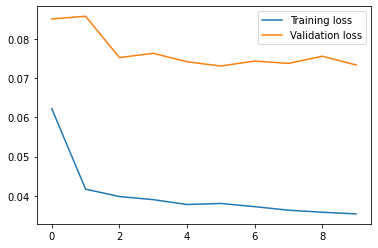

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [ ]:
trainPredict = model.predict(trainX)

4290/4290 [==============================] - 16s 4ms/step


In [ ]:
trainPredict

array([0.30426508], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))

In [ ]:
trainScore # varanasi data

0.1512435752090954

# Luckhnow Data

In [ ]:
df = pd.read_csv('lukhnow.csv')
df.head()

PeriodEnd           PeriodStart Period  AirTemp  Azimuth  \
0  2007-01-01T02:00:00Z  2007-01-01T01:00:00Z  PT60M     11.7     -116   
1  2007-01-01T03:00:00Z  2007-01-01T02:00:00Z  PT60M     12.3     -124   
2  2007-01-01T04:00:00Z  2007-01-01T03:00:00Z  PT60M     13.9     -133   
3  2007-01-01T05:00:00Z  2007-01-01T04:00:00Z  PT60M     16.6     -145   
4  2007-01-01T06:00:00Z  2007-01-01T05:00:00Z  PT60M     19.2     -160   

   CloudOpacity  DewpointTemp  Dhi  Dni  Ebh  ...  GtiFixedTilt  GtiTracking  \
0           2.2          10.1   13   12    1  ...            16           13   
1          16.3          10.4   81  139   37  ...           155          167   
2           0.0          10.8  157  390  150  ...           423          495   
3           0.0          11.3  207  503  260  ...           626          593   
4           0.0          11.8  246  538  324  ...           747          614   

   PrecipitableWater  RelativeHumidity  SnowWater  SurfacePressure  \
0               17.3              89.9        0.0           1004.0   
1               16.7              88.5        0.0           1004.6   
2               16.3              81.7        0.0           1005.0   
3               15.9              71.2        0.0           1005.1   
4               15.5              62.2        0.0           1005.2   

   WindDirection10m  WindSpeed10m  Zenith  AlbedoDaily  
0               307           1.7      90          0.2  
1               288           1.8      78          0.2  
2               282           2.0      68          0.2  
3               285           2.2      59          0.2  
4               288           2.4      53          0.2  

[5 rows x 21 columns]

In [ ]:
df.drop(columns =['PeriodEnd','Period','GtiFixedTilt','GtiTracking','Dhi','Ghi','Azimuth','Zenith','Dni','Ebh','SnowWater','WindDirection10m','AlbedoDaily'],axis =1,inplace =True)

In [ ]:
df.drop("CloudOpacity",axis=1,inplace =True)

In [ ]:
df.set_index(df['PeriodStart'], drop=False, append=False, inplace=True, verify_integrity=False)

In [ ]:
df['PeriodStart'] =pd.to_datetime(df.PeriodStart)

In [ ]:
df.head()

PeriodStart  AirTemp  DewpointTemp  \
PeriodStart                                                             
2007-01-01T01:00:00Z 2007-01-01 01:00:00+00:00     11.7          10.1   
2007-01-01T02:00:00Z 2007-01-01 02:00:00+00:00     12.3          10.4   
2007-01-01T03:00:00Z 2007-01-01 03:00:00+00:00     13.9          10.8   
2007-01-01T04:00:00Z 2007-01-01 04:00:00+00:00     16.6          11.3   
2007-01-01T05:00:00Z 2007-01-01 05:00:00+00:00     19.2          11.8   

                      PrecipitableWater  RelativeHumidity  SurfacePressure  \
PeriodStart                                                                  
2007-01-01T01:00:00Z               17.3              89.9           1004.0   
2007-01-01T02:00:00Z               16.7              88.5           1004.6   
2007-01-01T03:00:00Z               16.3              81.7           1005.0   
2007-01-01T04:00:00Z               15.9              71.2           1005.1   
2007-01-01T05:00:00Z               15.5              62.2           1005.2   

                      WindSpeed10m  
PeriodStart                         
2007-01-01T01:00:00Z           1.7  
2007-01-01T02:00:00Z           1.8  
2007-01-01T03:00:00Z           2.0  
2007-01-01T04:00:00Z           2.2  
2007-01-01T05:00:00Z           2.4

In [ ]:
cols = list(df)[1:7]

In [ ]:
cols

['AirTemp',
 'DewpointTemp',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindSpeed10m']

In [ ]:
df_for_training1 = df[cols].astype(float)

In [ ]:
df_for_training1

AirTemp  DewpointTemp  PrecipitableWater  \
PeriodStart                                                      
2007-01-01T01:00:00Z     11.7          10.1               17.3   
2007-01-01T02:00:00Z     12.3          10.4               16.7   
2007-01-01T03:00:00Z     13.9          10.8               16.3   
2007-01-01T04:00:00Z     16.6          11.3               15.9   
2007-01-01T05:00:00Z     19.2          11.8               15.5   
...                       ...           ...                ...   
2022-08-31T18:00:00Z     29.6          23.0               66.2   
2022-08-31T19:00:00Z     29.0          23.3               67.4   
2022-08-31T20:00:00Z     28.6          23.4               68.2   
2022-08-31T21:00:00Z     28.4          23.5               68.5   
2022-08-31T22:00:00Z     28.1          23.6               68.0   

                      RelativeHumidity  SurfacePressure  WindSpeed10m  
PeriodStart                                                            
2007-01-01T01:00:00Z              89.9           1004.0           1.7  
2007-01-01T02:00:00Z              88.5           1004.6           1.8  
2007-01-01T03:00:00Z              81.7           1005.0           2.0  
2007-01-01T04:00:00Z              71.2           1005.1           2.2  
2007-01-01T05:00:00Z              62.2           1005.2           2.4  
...                                ...              ...           ...  
2022-08-31T18:00:00Z              67.9            990.2           2.4  
2022-08-31T19:00:00Z              71.3            990.0           2.4  
2022-08-31T20:00:00Z              73.6            989.7           2.1  
2022-08-31T21:00:00Z              75.2            989.4           1.7  
2022-08-31T22:00:00Z              76.8            989.4           1.4  

[137326 rows x 6 columns]

<AxesSubplot:xlabel='PeriodStart'>

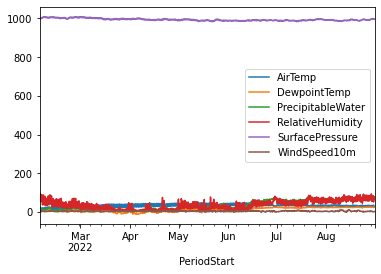

In [ ]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [ ]:
scaler1 = StandardScaler()
scaler1 = scaler.fit(df_for_training)
df_for_training_scaled1 = scaler.transform(df_for_training)

In [ ]:
df_for_training_scaled1.shape

(137302, 6)

In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 24  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
trainX.shape

(137278, 24, 6)

In [ ]:
trainY.shape

(137278, 1)

In [ ]:
trainx_new =trainX[:100000]

In [ ]:
trianY_new =trainY[:100000]

In [ ]:
trainx_new.shape

(100000, 24, 6)

In [ ]:
trianY_new.shape

(100000, 1)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainx_new.shape[1], trainx_new.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 64)            18176     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainx_new,trianY_new, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
5625/5625 [==============================] - 44s 8ms/step - loss: 0.0759 - val_loss: 0.0195
Epoch 2/10
5625/5625 [==============================] - 44s 8ms/step - loss: 0.0359 - val_loss: 0.0186
Epoch 3/10
5625/5625 [==============================] - 44s 8ms/step - loss: 0.0340 - val_loss: 0.0170
Epoch 4/10
5625/5625 [==============================] - 42s 8ms/step - loss: 0.0368 - val_loss: 0.0161
Epoch 5/10
5625/5625 [==============================] - 41s 7ms/step - loss: 0.0319 - val_loss: 0.0174
Epoch 6/10
5625/5625 [==============================] - 41s 7ms/step - loss: 0.0318 - val_loss: 0.0152
Epoch 7/10
5625/5625 [==============================] - 41s 7ms/step - loss: 0.0314 - val_loss: 0.0147
Epoch 8/10
5625/5625 [==============================] - 43s 8ms/step - loss: 0.0306 - val_loss: 0.0141
Epoch 9/10
5625/5625 [==============================] - 42s 8ms/step - loss: 0.0298 - val_loss: 0.0161
Epoch 10/10
5625/5625 [==============================] - 43s 8ms/step - l

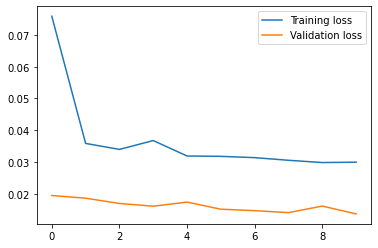

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
trainPredict = model.predict(trainX)

4290/4290 [==============================] - 17s 4ms/step


In [ ]:
trainPredict.plo

(137278, 1)

In [ ]:
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))

In [ ]:
trainScore

0.17602469966062045

In [ ]:
testx =trainX[100000:]

In [ ]:
testy =trainY[100000:]

In [ ]:
testy

array([[ 0.26533059],
       [ 0.41156849],
       [ 0.48468744],
       ...,
       [-0.02714521],
       [-0.17338312],
       [-0.17338312]])

In [ ]:
testPredict = model.predict(testx)

1165/1165 [==============================] - 5s 4ms/step


In [ ]:
testPredict

array([[ 0.15939128],
       [ 0.46593937],
       [ 0.4653367 ],
       ...,
       [-0.09503485],
       [-0.17112952],
       [-0.38013563]], dtype=float32)

In [ ]:
trainScore = np.sqrt(mean_squared_error(testy, testPredict))

In [ ]:
trainScore

0.2882193640731349

# Ahmedabad Data

In [ ]:
df1 =pd.read_csv("Ahmedabad.csv")

In [ ]:
df1.drop(columns =['PeriodEnd','Period','GtiFixedTilt','GtiTracking','Dhi','Ghi','Azimuth','Zenith','Dni','Ebh','SnowWater','WindDirection10m','AlbedoDaily'],axis =1,inplace =True)

In [ ]:
df1.drop("CloudOpacity",axis=1,inplace =True)

In [ ]:
df1['PeriodStart'] =pd.to_datetime(df.PeriodStart)

In [ ]:
df1.dtypes

PeriodStart          datetime64[ns, UTC]
AirTemp                          float64
DewpointTemp                     float64
PrecipitableWater                float64
RelativeHumidity                 float64
SurfacePressure                  float64
WindSpeed10m                     float64
dtype: object

In [ ]:
df1.set_index(df1['PeriodStart'], drop=False, append=False, inplace=True, verify_integrity=False)

In [ ]:
df

PeriodStart  AirTemp  DewpointTemp  \
PeriodStart                                                                  
2007-01-01 01:00:00+00:00 2007-01-01 01:00:00+00:00     11.7          10.1   
2007-01-01 02:00:00+00:00 2007-01-01 02:00:00+00:00     12.3          10.4   
2007-01-01 03:00:00+00:00 2007-01-01 03:00:00+00:00     13.9          10.8   
2007-01-01 04:00:00+00:00 2007-01-01 04:00:00+00:00     16.6          11.3   
2007-01-01 05:00:00+00:00 2007-01-01 05:00:00+00:00     19.2          11.8   
...                                             ...      ...           ...   
2022-08-31 18:00:00+00:00 2022-08-31 18:00:00+00:00     29.6          23.0   
2022-08-31 19:00:00+00:00 2022-08-31 19:00:00+00:00     29.0          23.3   
2022-08-31 20:00:00+00:00 2022-08-31 20:00:00+00:00     28.6          23.4   
2022-08-31 21:00:00+00:00 2022-08-31 21:00:00+00:00     28.4          23.5   
2022-08-31 22:00:00+00:00 2022-08-31 22:00:00+00:00     28.1          23.6   

                           PrecipitableWater  RelativeHumidity  \
PeriodStart                                                      
2007-01-01 01:00:00+00:00               17.3              89.9   
2007-01-01 02:00:00+00:00               16.7              88.5   
2007-01-01 03:00:00+00:00               16.3              81.7   
2007-01-01 04:00:00+00:00               15.9              71.2   
2007-01-01 05:00:00+00:00               15.5              62.2   
...                                      ...               ...   
2022-08-31 18:00:00+00:00               66.2              67.9   
2022-08-31 19:00:00+00:00               67.4              71.3   
2022-08-31 20:00:00+00:00               68.2              73.6   
2022-08-31 21:00:00+00:00               68.5              75.2   
2022-08-31 22:00:00+00:00               68.0              76.8   

                           SurfacePressure  WindSpeed10m  
PeriodStart                                               
2007-01-01 01:00:00+00:00           1004.0           1.7  
2007-01-01 02:00:00+00:00           1004.6           1.8  
2007-01-01 03:00:00+00:00           1005.0           2.0  
2007-01-01 04:00:00+00:00           1005.1           2.2  
2007-01-01 05:00:00+00:00           1005.2           2.4  
...                                    ...           ...  
2022-08-31 18:00:00+00:00            990.2           2.4  
2022-08-31 19:00:00+00:00            990.0           2.4  
2022-08-31 20:00:00+00:00            989.7           2.1  
2022-08-31 21:00:00+00:00            989.4           1.7  
2022-08-31 22:00:00+00:00            989.4           1.4  

[137326 rows x 7 columns]

In [ ]:
cols = list(df)[1:7]

In [ ]:
df_for_training1 = df[cols].astype(float)

In [ ]:
df_for_training1

AirTemp  DewpointTemp  PrecipitableWater  \
PeriodStart                                                           
2007-01-01 01:00:00+00:00     11.7          10.1               17.3   
2007-01-01 02:00:00+00:00     12.3          10.4               16.7   
2007-01-01 03:00:00+00:00     13.9          10.8               16.3   
2007-01-01 04:00:00+00:00     16.6          11.3               15.9   
2007-01-01 05:00:00+00:00     19.2          11.8               15.5   
...                            ...           ...                ...   
2022-08-31 18:00:00+00:00     29.6          23.0               66.2   
2022-08-31 19:00:00+00:00     29.0          23.3               67.4   
2022-08-31 20:00:00+00:00     28.6          23.4               68.2   
2022-08-31 21:00:00+00:00     28.4          23.5               68.5   
2022-08-31 22:00:00+00:00     28.1          23.6               68.0   

                           RelativeHumidity  SurfacePressure  WindSpeed10m  
PeriodStart                                                                 
2007-01-01 01:00:00+00:00              89.9           1004.0           1.7  
2007-01-01 02:00:00+00:00              88.5           1004.6           1.8  
2007-01-01 03:00:00+00:00              81.7           1005.0           2.0  
2007-01-01 04:00:00+00:00              71.2           1005.1           2.2  
2007-01-01 05:00:00+00:00              62.2           1005.2           2.4  
...                                     ...              ...           ...  
2022-08-31 18:00:00+00:00              67.9            990.2           2.4  
2022-08-31 19:00:00+00:00              71.3            990.0           2.4  
2022-08-31 20:00:00+00:00              73.6            989.7           2.1  
2022-08-31 21:00:00+00:00              75.2            989.4           1.7  
2022-08-31 22:00:00+00:00              76.8            989.4           1.4  

[137326 rows x 6 columns]

<AxesSubplot:xlabel='PeriodStart'>

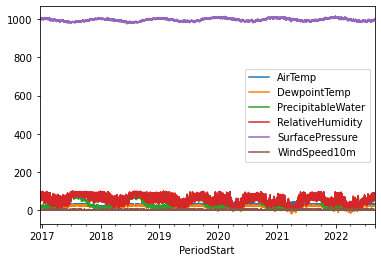

In [ ]:
df_for_plot=df_for_training.tail(50000)
df_for_plot.plot.line()

In [ ]:
scaler1 = StandardScaler()
scaler1 = scaler.fit(df_for_training)
df_for_training_scaled1 = scaler.transform(df_for_training)

In [ ]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 24  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
trainx_new1 =trainX[:100000]

In [ ]:
trianY_new1 =trainY[:100000]

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainx_new1.shape[1], trainx_new1.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            18176     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model.fit(trainx_new1,trianY_new1, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
5625/5625 [==============================] - 48s 8ms/step - loss: 0.0571 - val_loss: 0.0192
Epoch 2/10
5625/5625 [==============================] - 43s 8ms/step - loss: 0.0347 - val_loss: 0.0187
Epoch 3/10
5625/5625 [==============================] - 43s 8ms/step - loss: 0.0319 - val_loss: 0.0165
Epoch 4/10
5625/5625 [==============================] - 44s 8ms/step - loss: 24.8123 - val_loss: 0.0167
Epoch 5/10
5625/5625 [==============================] - 45s 8ms/step - loss: 0.0297 - val_loss: 0.0156
Epoch 6/10
5625/5625 [==============================] - 49s 9ms/step - loss: 0.0288 - val_loss: 0.0155
Epoch 7/10
5625/5625 [==============================] - 46s 8ms/step - loss: 0.0287 - val_loss: 0.0168
Epoch 8/10
5625/5625 [==============================] - 45s 8ms/step - loss: 0.0292 - val_loss: 0.0152
Epoch 9/10
5625/5625 [==============================] - 45s 8ms/step - loss: 0.0292 - val_loss: 0.0141
Epoch 10/10
5625/5625 [==============================] - 43s 8ms/step - 

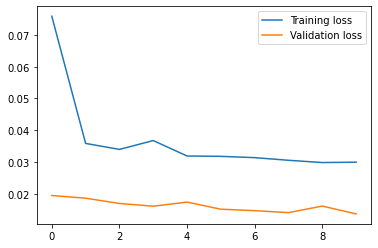

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
trainPredict = model.predict(trainX)

4290/4290 [==============================] - 18s 4ms/step


In [ ]:
testPredict

array([[ 0.15939128],
       [ 0.46593937],
       [ 0.4653367 ],
       ...,
       [-0.09503485],
       [-0.17112952],
       [-0.38013563]], dtype=float32)

In [ ]:
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))

In [ ]:
trainScore

0.19898666748904745

In [ ]:
trainPredict12 = model.predict(trainX[100000:])

1165/1165 [==============================] - 5s 4ms/step


In [ ]:
trainScore = np.sqrt(mean_squared_error(trainY[100000:], trainPredict12))

In [ ]:
trainScore

0.33246562065431473